# Using Clustering to Reduce Log Error in Zillow Dataset

## Project Plan

### Goals
- Use clustering methodologies
- Identify what is driving the difference in zestimate to sales price "logerror"
- Build a model to predict your target "logerror"

### Hypothesis
- Noteable clusters will be found based on location
- A model containing the clusters will better predict logerror than a baseline model of the average logerror

### Components
- Clusters
- Teach others
- Use statistical tests
- Visualize to explore
- Scale
- Impute
- Feature engineering
- Code resuseability/modularity
- Stages of pipeline

### Data Dictionary

| variable | contents |
|---|---|
| home_cluster  | this contains clusters created around house_area, land_area, & yearbuilt  |
| house_area  | this is the square footage of the structure  |
| land_area  | this is the square footage of the land (not including structure)  |
| yearbuilt | this is the year the structure was built  |
| location_cluster | this contains clusters created around latitude, longitude, & taxrate  |
| latititude  | this is the latitude value of the structure  |
| longitude  | this is the longitude value of the structure  |
| taxrate | this is the tax value of the whole thing (structure + land) divided by tax amount of the whole thing  |
| house_value  | this is the dollar value of the structure  |
| land_value  | this is the dollar value of the land (not including the structure)  |


In [1]:
import acquire
import prep
import split_scale
import explore
import model

from sklearn.metrics import median_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

from scipy import stats

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Acquire

### Pull SQL data and filter data frame

Using the `get_sql_zillow` function from the `acquire` module, pull all the columns from the Zillow dataset from SQL following the conditions below:
 - only include properties that have recorded transactions in 2017
 - use a left join to merge all tables of descriptions on their associated id property
 - exclude properties that do not have latitude and longitude values (location is important in our analysis later so we wante to make sure we are including observations with known locations.)

> Due to long run times when connecting with the SQL server, we exported a CSV out of the SQL query with identical conditions as above.

In [2]:
# uncomment to read from appropriate local source.
# df = pd.read_csv(r'/Users/mists/codeup-data-science/zillow-cluster/query_result.csv')
df = pd.read_csv(r'/Users/cris/codeup-data-science/zillow-cluster/query_result.csv')

Using the `wrangle_zillow` function, perform initial cleaning of the original dataframe specifically:
 - Drop redundant ID columns from Left Joins (typeconstructionid, storytypeid, etc.)
 - Remove duplicates from multiple transactions by maintaining latest transaction date and dropping previous records
 - Include property land use type "Single Family Residential" only, and drop the rest of the observations
 - Drop properties that have unit counts of 2 (27 rows) and 3 (1 row) to remove ambiguity in the definition of "single-unit" or "single-family" houses, especially since the total number of these observations are relatively minimal.
 - Keep transactions that are recorded in 2017 (there was 1 row that has 2018 as transaction year)

In [3]:
df = acquire.wrangle_zillow(df)

In [4]:
df.info() #we can see that our current data set is messy with plenty of nulls and some empty columns!

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52292 entries, 77578 to 0
Data columns (total 61 columns):
parcelid                        52292 non-null int64
basementsqft                    47 non-null float64
bathroomcnt                     52292 non-null float64
bedroomcnt                      52292 non-null int64
buildingqualitytypeid           33632 non-null float64
calculatedbathnbr               52158 non-null float64
decktypeid                      388 non-null float64
finishedfloor1squarefeet        4368 non-null float64
calculatedfinishedsquarefeet    52211 non-null float64
finishedsquarefeet12            52047 non-null float64
finishedsquarefeet13            0 non-null float64
finishedsquarefeet15            0 non-null float64
finishedsquarefeet50            4368 non-null float64
finishedsquarefeet6             164 non-null float64
fips                            52292 non-null int64
fireplacecnt                    7230 non-null float64
fullbathcnt                     521

## Preprocess

### A. Handle missing values

**Drop Unsalvagable Columns and Rows**

`handle_missing_values` function from the `prep` module drops columns that are 90% empty, reducing our columns from 60 to 27. Then, remove observations that are 40% empty. The latter removed no observations.  
  
In this stage, our working data has 52292 rows with 27 columns.

In [5]:
df = prep.handle_missing_values(df,.90,.40)

**Drop Non-value-adding Columns**

Throughout the process, we will be using the index to identify each oservation, therefore we are dropping the `parcelid`.

`bathroomcnt` reflects the same information as the `calculatedbathnbr`, which is the number of bathrooms in a property including half bathrooms (.5's). The	`fullbathcnt` column only includes full bathrooms and discounts half baths. So, we are discarding redundant `calculatedbathnbr` and `fullbathcnt` and keep `bathroomcnt` to provide information on the properties' bathrooms.

`calculatedfinishedsquarefeet` and `finishedsquarefeet12` hold practically the same information. `calculatedfinishedsquarefeet` has less nulls (81 rows) than `finishedsquarefeet12` (245 rows), so we are dropping the `finishedsquarefeet12`.

`propertycountylandusecode` are codes used in the industry to specify the land use. For example, a Single Family Residential property land use type may be Single Family Class II (0102), Vacant Residential (0000), Vacant Lake View (0035), etc. We don't need these further information. All we need to know is that the properties that we are looking at are under the umbrella of "Single Family Residential."

`rawcensustractandblock` and `censustractandblock` contain census information that we are not concerned about in this project.

`roomcnt` has 37,588 properties with 0 rooms, so we are dropping this column.

`fips` and `regionidcounty` have cotain the same information. We will keep the `fips` column.

`regionidzip` and `regionidcity` are location-based columns which do not give much added information on the properties' location given that we have `latitude` and `longitude`. These columns are dropped.

All wrangled observation have "2016" as values in the `assessmentyear` which is not adding value to the analysis.

`propertylandusedesc` is dropped because it only displays "Single Family Residential" which was helpful in the filtering phase but not useful in the analysis.

Call `clean_columns` from the `prep` module to drop the columns we stated above.

In [6]:
df = prep.clean_columns(df)

**Handle Nulls for Relevant Columns**

In [7]:
# Let's look at the remaining null values
df.isnull().sum()

bathroomcnt                       0
bedroomcnt                        0
calculatedfinishedsquarefeet     81
fips                              0
latitude                          0
longitude                         0
lotsizesquarefeet               362
yearbuilt                       114
structuretaxvaluedollarcnt       79
taxvaluedollarcnt                 1
landtaxvaluedollarcnt             1
taxamount                         4
id.1                              0
logerror                          0
transactiondate                   0
dtype: int64

_Calculated Finished Square Feet, Structure Tax Value Dollar Count_ -  observations that have missing values in either `calculatedfinishedsquarefeet` (71 rows) or  `structuretaxvaluedollarcnt` (69 rows), both (10 rows) are dropped, removing a total of 150 observations.

_Tax Value Dollar Count, Land Tax Value Dollar Count_ - there are a handful of observations with missing values in the columns `taxvaluedollarcnt` (1 row), `landtaxvaluedollarcnt` (1 row), `taxamount` (4 rows).

_Year Built_ - After all the above removals, `yearbuilt` have a total of 38 missing values which are dropped because of the manageable size.

Call `drop_minimal_nulls` from the `prep` module to drop the missing observations as explained above.

In [8]:
df = prep.drop_minimal_nulls(df)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52101 entries, 77578 to 0
Data columns (total 15 columns):
bathroomcnt                     52101 non-null float64
bedroomcnt                      52101 non-null int64
calculatedfinishedsquarefeet    52101 non-null float64
fips                            52101 non-null int64
latitude                        52101 non-null int64
longitude                       52101 non-null int64
lotsizesquarefeet               51761 non-null float64
yearbuilt                       52101 non-null float64
structuretaxvaluedollarcnt      52101 non-null float64
taxvaluedollarcnt               52101 non-null float64
landtaxvaluedollarcnt           52101 non-null float64
taxamount                       52101 non-null float64
id.1                            52101 non-null int64
logerror                        52101 non-null float64
transactiondate                 52101 non-null object
dtypes: float64(9), int64(5), object(1)
memory usage: 6.4+ MB


After handling all missing values, we now have a clean data set with 52,101 observations!

### B. Rename and reorder columns

`pretty_cols` is a function from the `prep` module that lets us rename the remaining features with more intuitive names for two purposes:
 - understandability - we know exactly what we are looking at
 - efficiency - easier to remember and call on our codes later; it can minimize errors based on typo mistakes too!

In [10]:
df = prep.pretty_cols(df)

In [11]:
print(f"""
      These are the remaining features after handling all the missing values:
      {list(df.columns)}
      """)


      These are the remaining features after handling all the missing values:
      ['countyid', 'latitude', 'longitude', 'yearbuilt', 'bathroomcnt', 'bedroomcnt', 'house_area', 'whole_area', 'house_value', 'land_value', 'whole_value', 'taxamount', 'logerror', 'transactiondate']
      


### C. Derive Features

Derive `taxrate` from `taxamount` and `taxvaluedollarcnt` using the `cal_taxrate` function.

In [12]:
df = prep.cal_taxrate(df)

As all transactions are in 2017, take only the month from the transaction date for the exploration phase.

In [13]:
df = prep.define_month(df)

### D. Split Train and Test

Split dataframe into train and test using the `split_my_data` function from `split_scale` module. The random seed was set to 123 for reproducibility.

In [14]:
train, test = split_scale.split_my_data(df, .80)

In [15]:
print("Train Data")
print(train.info())
print()
print("Test Data")
print(test.info())

Train Data
<class 'pandas.core.frame.DataFrame'>
Int64Index: 41680 entries, 28235 to 54472
Data columns (total 14 columns):
countyid       41680 non-null int64
latitude       41680 non-null int64
longitude      41680 non-null int64
yearbuilt      41680 non-null float64
bathroomcnt    41680 non-null float64
bedroomcnt     41680 non-null int64
house_area     41680 non-null float64
whole_area     41405 non-null float64
house_value    41680 non-null float64
land_value     41680 non-null float64
whole_value    41680 non-null float64
logerror       41680 non-null float64
taxrate        41680 non-null float64
month          41680 non-null int64
dtypes: float64(9), int64(5)
memory usage: 4.8 MB
None

Test Data
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10421 entries, 37917 to 44340
Data columns (total 14 columns):
countyid       10421 non-null int64
latitude       10421 non-null int64
longitude      10421 non-null int64
yearbuilt      10421 non-null float64
bathroomcnt    10421 non-null

### E. Impute remaining nulls

`whole_area` still contain null values (275 rows on train, 65 rows on test). Because of the number, we determined that imputing based on a derived values based on values that we do know.

It is important to note that the imputing process has to be done after the split because we want to calculate the imputed values based on a value derived from the train data exclusively.

In [16]:
print(train.isnull().sum())
print()
print(test.isnull().sum())

countyid         0
latitude         0
longitude        0
yearbuilt        0
bathroomcnt      0
bedroomcnt       0
house_area       0
whole_area     275
house_value      0
land_value       0
whole_value      0
logerror         0
taxrate          0
month            0
dtype: int64

countyid        0
latitude        0
longitude       0
yearbuilt       0
bathroomcnt     0
bedroomcnt      0
house_area      0
whole_area     65
house_value     0
land_value      0
whole_value     0
logerror        0
taxrate         0
month           0
dtype: int64


The process for imputing `whole_area` is the less straightforward compared to the missing values above.

In essence, `whole_area` is the sum of the area of the land without structure (land or dirt) and the finished space (structure or house).

The process for filling the missing values on `whole_area` is as follows:

1. Derive the total tax dollar amount of the lot by adding the tax value of the land and the tax value of the structure

  $ value_{lot} = value_{land} + value_{structure} $
  
  
2. Get the proportion of the lot area and the lot tax value from non-missing values.

  $ proportion = \frac {area_{lot}}{value_{lot}} $
  

3. There were unrealistic proportions which seem to come from properties that have a big lot area but low tax value. At 75 percentile, we see a proportion of 0.041 and a mean of 0.048. Because of this, we are confident to take the mean of all proportions less than 1 (proportion < 1). The mean will inform us a generalized value for the lot square footage, i.e., $area_{lot}$, given the total lot value, i.e., $value_{lot}$.

  
4. Impute the nulls in the `whole_area` aka $area_{lot}$ using the derived formula:

  $ area_{lot} = value_{lot} * \mu_{proportion} $

In [17]:
train, test = prep.impute_lotsize_nulls(train, test)

The derivations are from the value of the train but imputation were made to both train and test so we have a clean data to work with moving forward.

Now that we have complete values for the `whole_area` column, we can calculate the land area by subtracting `whole_area` i.e., the entire lot, and the `house_area`, i.e., the total finished area. `cal_land_area` function accomplishes this computation and feature addition.

In [18]:
train = prep.cal_land_area(train)
test = prep.cal_land_area(test)

## Explore

All the functions we used to explore the data are from the `explore` module.

**Questions we want to answer from the exploratory phase:**

1. What are the distribution of data based on the present features? Are there anything that's worth noting?
2. Are there distinguishable clusters per month/season? In other words, can we find distinct groups of transactions within the active months of 2017? Are there more types of houses/locations sold in a particular period of the year?
3. Are there distinguishable clusters in the properties' age (based on `yearbuilt`)? Based on the properties' age, can we find groups of properties that have comparable features or location?
4. Grouping the features based on their intrinsic traits (house-based, location-based, valuation-based features), what are the respective features that correlate to logerror (feature vs target) and with each other (feature vs feature). Knowing these will guide further exploration and the features to maintain and drop.
5. Are there specific clusters that generate logerror?

<div class="alert alert-block alert-info">
<b>QUESTION 1:</b>  
What are the distribution of data based on the remaining features? Are there anything that's worth noting?
</div>

Using distribution plot and value counts, let's take a peek at the features we have.

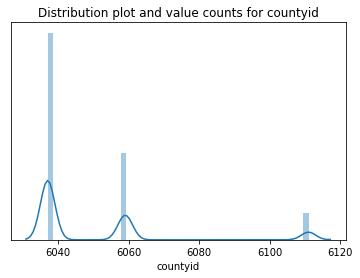

6037    26935
6059    11286
6111     3459
Name: countyid, dtype: int64


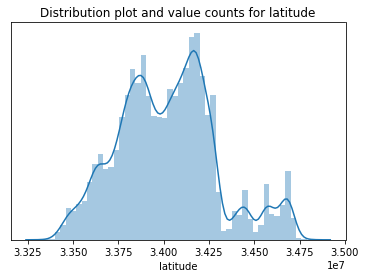

(33339141.852, 33488434.7]     604
(33488434.7, 33636249.4]      2592
(33636249.4, 33784064.1]      4821
(33784064.1, 33931878.8]      8734
(33931878.8, 34079693.5]      7230
(34079693.5, 34227508.2]      9859
(34227508.2, 34375322.9]      3678
(34375322.9, 34523137.6]      1455
(34523137.6, 34670952.3]      1694
(34670952.3, 34818767.0]      1013
Name: latitude, dtype: int64


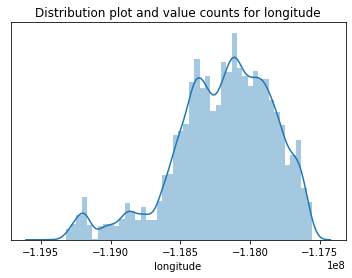

(-119477336.044, -119283411.7]     119
(-119283411.7, -119091407.4]      1025
(-119091407.4, -118899403.1]       825
(-118899403.1, -118707398.8]      1425
(-118707398.8, -118515394.5]      3037
(-118515394.5, -118323390.2]      7402
(-118323390.2, -118131385.9]      8012
(-118131385.9, -117939381.6]      8948
(-117939381.6, -117747377.3]      7280
(-117747377.3, -117555373.0]      3607
Name: longitude, dtype: int64


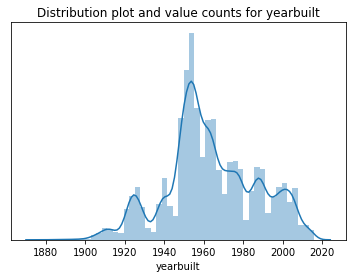

(1877.861, 1891.8]       20
(1891.8, 1905.6]        141
(1905.6, 1919.4]        826
(1919.4, 1933.2]       3242
(1933.2, 1947.0]       3905
(1947.0, 1960.8]      12687
(1960.8, 1974.6]       8201
(1974.6, 1988.4]       5508
(1988.4, 2002.2]       4719
(2002.2, 2016.0]       2431
Name: yearbuilt, dtype: int64


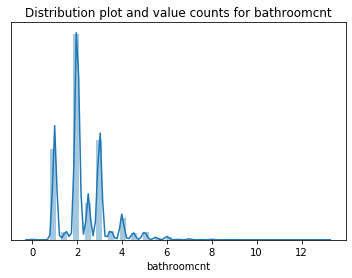

2.0     17401
3.0      8472
1.0      7639
2.5      3138
4.0      1808
3.5       733
1.5       675
5.0       635
4.5       534
6.0       252
5.5       188
7.0        70
8.0        39
6.5        37
0.0        28
7.5        13
9.0        10
10.0        3
8.5         2
11.0        2
13.0        1
Name: bathroomcnt, dtype: int64


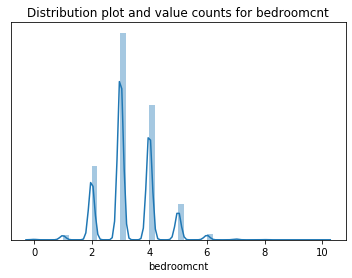

3     18606
4     12129
2      6655
5      3181
6       497
1       464
7        81
0        42
8        18
9         5
10        2
Name: bedroomcnt, dtype: int64


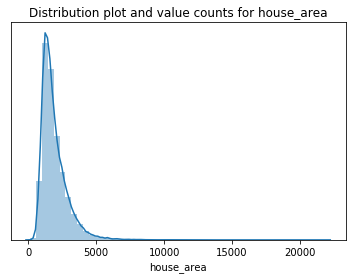

(106.198, 2308.1]     31269
(2308.1, 4488.2]       9457
(4488.2, 6668.3]        790
(6668.3, 8848.4]        119
(8848.4, 11028.5]        31
(11028.5, 13208.6]        9
(13208.6, 15388.7]        1
(15388.7, 17568.8]        2
(17568.8, 19748.9]        0
(19748.9, 21929.0]        2
Name: house_area, dtype: int64


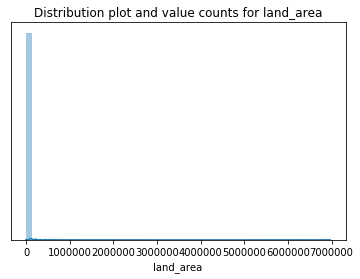

(-9303.114, 694880.3]     41665
(694880.3, 1392091.6]         7
(1392091.6, 2089302.9]        0
(2089302.9, 2786514.2]        1
(2786514.2, 3483725.5]        0
(3483725.5, 4180936.8]        0
(4180936.8, 4878148.1]        0
(4878148.1, 5575359.4]        0
(5575359.4, 6272570.7]        0
(6272570.7, 6969782.0]        7
Name: land_area, dtype: int64


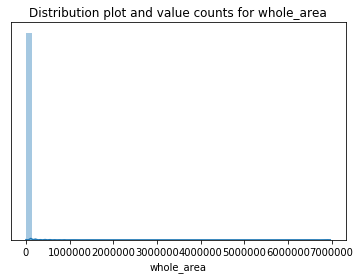

(-6734.775000000001, 697313.4]    41665
(697313.4, 1394390.8]                 7
(1394390.8, 2091468.2]                0
(2091468.2, 2788545.6]                1
(2788545.6, 3485623.0]                0
(3485623.0, 4182700.4]                0
(4182700.4, 4879777.8]                0
(4879777.8, 5576855.2]                0
(5576855.2, 6273932.6]                0
(6273932.6, 6971010.0]                7
Name: whole_area, dtype: int64


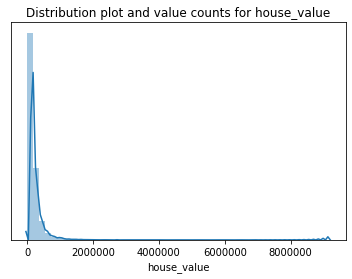

(-9035.773000000001, 916606.2]    40965
(916606.2, 1833083.4]               591
(1833083.4, 2749560.6]               79
(2749560.6, 3666037.8]               29
(3666037.8, 4582515.0]                6
(4582515.0, 5498992.2]                3
(5498992.2, 6415469.4]                1
(6415469.4, 7331946.6]                1
(7331946.6, 8248423.8]                4
(8248423.8, 9164901.0]                1
Name: house_value, dtype: int64


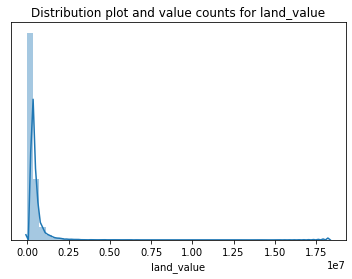

(-18113.34, 1827594.9]      41093
(1827594.9, 3655028.8]        459
(3655028.8, 5482462.7]         76
(5482462.7, 7309896.6]         31
(7309896.6, 9137330.5]          9
(9137330.5, 10964764.4]         5
(10964764.4, 12792198.3]        3
(12792198.3, 14619632.2]        1
(14619632.2, 16447066.1]        2
(16447066.1, 18274500.0]        1
Name: land_value, dtype: int64


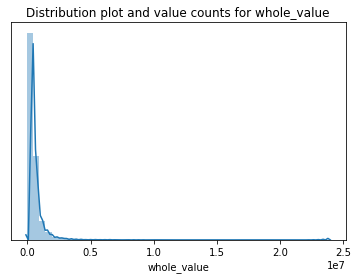

(-20601.121, 2388766.0]     40929
(2388766.0, 4774278.0]        595
(4774278.0, 7159790.0]        104
(7159790.0, 9545302.0]         27
(9545302.0, 11930814.0]        10
(11930814.0, 14316326.0]        7
(14316326.0, 16701838.0]        2
(16701838.0, 19087350.0]        2
(19087350.0, 21472862.0]        2
(21472862.0, 23858374.0]        2
Name: whole_value, dtype: int64


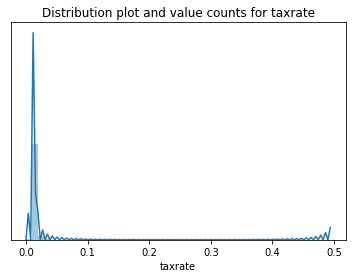

(-0.0014, 0.0494]    41611
(0.0494, 0.0988]        50
(0.0988, 0.148]         12
(0.148, 0.198]           2
(0.198, 0.247]           1
(0.247, 0.296]           1
(0.296, 0.346]           1
(0.346, 0.395]           0
(0.395, 0.444]           0
(0.444, 0.494]           2
Name: taxrate, dtype: int64


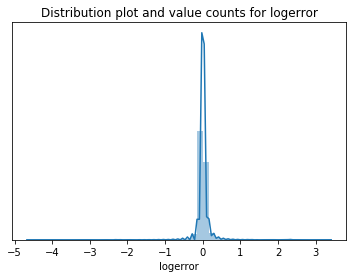

(-4.664000000000001, -3.85]        2
(-3.85, -3.045]                    0
(-3.045, -2.24]                   13
(-2.24, -1.435]                   15
(-1.435, -0.63]                   99
(-0.63, 0.175]                 39273
(0.175, 0.98]                   2120
(0.98, 1.785]                     85
(1.785, 2.59]                     65
(2.59, 3.395]                      8
Name: logerror, dtype: int64


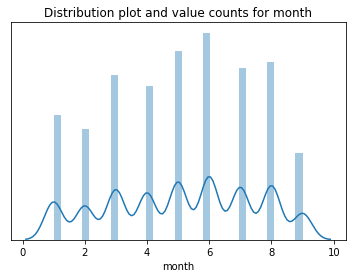

6    6229
5    5693
8    5342
7    5165
3    4948
4    4619
1    3741
2    3336
9    2607
Name: month, dtype: int64


In [19]:
explore.features_num_values(train)

In [20]:
train.whole_value.median()

373759.5

<div class="alert alert-block alert-info">
<b>TAKEAWAYS:</b>  
    
- In the three counties that we are surveying, a notably large volume of houses were built in mid-1940s (post-war) to late-1950s.  
- Typical bathroom count is 2.  
- Typical bedroom count is 3.  
- Most properties in our data have a ~4500 sqft or less.  
- There are a handful (8) of properties in our data that are situated in a total land area of more than 15 acres.
- A typical property (land and house) in the three counties grosses to around \$ 374,000
</div>

<div class="alert alert-block alert-info">
<b>QUESTION 2:</b>  
Are there distinguishable clusters per month/season? In other words, can we find distinct groups of transactions within the active months of 2017? Are there more types of houses/locations sold in a particular period of the year?
</div>

Look for clusters in months.

In [21]:
# explore.k_cluster_all(train, "month", 5)

<div class="alert alert-block alert-info">
<b>TAKEAWAY:</b>  
    
- There are no distinct clusters (house properties, location) by looking at specific features.
</div>

<div class="alert alert-block alert-info">
<b>QUESTION 3:</b>  
Are there distinguishable clusters in the properties' age (based on yearbuilt)? Based on the properties' age, can we find groups of properties that have comparable features or location?
</div>

In [22]:
# explore.k_cluster_all(train, "yearbuilt", 5)

<div class="alert alert-block alert-info">
<b>TAKEAWAY:</b>  
    
- There are distinguishable clusters in `land_value` and `house_value` when mapped across year built. This informs us that `yearbuilt` gives information that we may want to include as an intrinsic trait of the property. Therefore, we will keep this feature.

- It is interesting to note that there are no pre-1920 properties that are valuated above 2M, unlike properties built at a later time.

In [23]:
# explore.k_cluster_all(train, "latitude", 5)

In [24]:
# explore.k_cluster_all(train, "longitude", 5)

There are noticable clusters in latitude and longitude. As well as latitude and longitude with house area. Will explore both more. 

In [25]:
# explore.elbow(train[["latitude","longitude"]])

In [26]:
# explore.k_cluster_2d(train, "latitude", "longitude", 7, 3)

We will use a temporary data frame `train_ex` with all the attributes (inclusing logerror, our target) scaled for the exploration phase to enable us to liberally use statistical methods like pearson's correlation and t-test later.

`train_ex` is an exploration-version of train:
    - without the transaction date
    - scaled to normal distribution

The scaler function from the `split_scale` module requires a test data frame as a parameter. Hence, even though we will not use `test_ex` in the exploration phase, we will feed it into the scaler and set it aside.

In [27]:
train_ex = train[["logerror","bathroomcnt","bedroomcnt","house_area","land_area","whole_area",
                  "yearbuilt","latitude","longitude","taxrate","house_value","land_value","whole_value"]]
test_ex = test[["logerror","bathroomcnt","bedroomcnt","house_area","land_area","whole_area",
                "yearbuilt","latitude","longitude","taxrate","house_value","land_value","whole_value"]]

In [28]:
train_ex, test_ex, scaler = split_scale.standard_scaler(train_ex, test_ex)

It would be a challenge to explore with all the features, let's separate them in groups that make sense:

- Home-based features
- Location-based features
- Valuation-based (or money-related) features

In [29]:
train_ex_home = train_ex[["logerror","bathroomcnt","bedroomcnt","house_area","land_area","whole_area","yearbuilt"]]
train_ex_loc = train_ex[["logerror","latitude","longitude","taxrate"]]
train_ex_val = train_ex[["logerror","house_value","land_value","whole_value"]]

In [30]:
# sns.pairplot(train_ex_home)
# plt.show()

In [31]:
# sns.heatmap(train_ex_home.corr(), annot=True)
# plt.show()

`bathroomcnt` and `bedroomcnt` have strong positive correlation with `house_area`. These features can be dropped. Likewise, `land_area` is a derivative of the data we know previously which was `whole_area` (prev. lotsize) so they're very strongly correlated. We can drop the `whole_area` for now.
  
Recall that `land_area` is a derived feature from finished sqft and lot size. We inferred that a big house, does not always entail a big land which is why we separated land and house area in the first place. Seeing a low (0.15) correlation between `land_area` and `house_area` confirms that it was a good move to separate these features.
  
It's also interesting to note that `house_area` has a fairly strong positive correlation with `yearbuilt` and it's probably due to the style of house built during that era (craftsman, neoclassical, ranch style, etc.). Even if they are correlated, year built provides a distinct information on the property so we will keep it.

In [32]:
# sns.pairplot(train_ex_loc)
# plt.show()

In [33]:
# sns.heatmap(train_ex_loc.corr(),annot=True)
# plt.show()

No correlations stand out from the house group, but it's worth noting that `latitude` and `longitude` have strong negative correlation. It means that as we move eastwards, we move southwards, which geographically makes sense as we are considering counties in Los Angeles (forms a downsloping diagonal line).

The `tax_rate` has some correlation with `latitude`.

In [34]:
# sns.pairplot(train_ex_val)
# plt.show()

In [35]:
# sns.heatmap(train_ex_val.corr(),annot=True)
# plt.show()

`whole_value` is the sum of `land_value` and `house_value`, so a positive high correlation of .95 and .85 is expected. We can drop `whole_value` as a feature for the model.

<div class="alert alert-block alert-info">
<b>TAKEAWAYS:</b>  
    
- None of the features seem to highly correlate with logerror. But it makes me think that its possibly because of two things:
    1. Logerror is a derived feature. It's not as straightforward as property value.
    2. Logerror is drived by a summation of different things, random and predictable. It's a multi-dimensional problem that needs more than x predicts y.
- Pearson's r does not show statistical significance. Instead of thinking that none of these features drive logerror, it strengthens the idea of exploring clustering more to address the dimensionality of the features.
- With the above being said, instead of using pearson's r to both (1) see strong drivers in explaining logerror, and (2) check for multicollinear features, we will only use it to address multicollinearity and inform us what features to drop.
- **Features to Keep based on Pearson's Correlation**
 - Home Group  
   - land_area  
   - house_area  
   - yearbuilt  
 - Location Group  
   - latitude  
   - longitude    
   - taxrate  
 - Valuation Group  
   - house_value  
   - land_value  

</div>

### Feature Engineering

Now that we have identified the most relevant features per group, we will explore if there are noticeable clusters in each feature group.

We need to scale home and loc features because K-Means uses distance as a method for clustering. To maintain the relative distance of each data points while being synced to a uniform scale, we will use a MinMax scaler from the `split_scale` module.

In [36]:
train_home = train[["house_area","land_area","yearbuilt"]]
test_home = test[["house_area","land_area","yearbuilt"]]

train_loc = train[["latitude","longitude","taxrate"]]
test_loc = test[["latitude","longitude","taxrate"]]

train_val = train[["house_value","land_value"]]
test_val = test[["house_value","land_value"]]

In [37]:
train_home, test_home, scaler = split_scale.min_max_scaler(train_home, test_home)

In [38]:
train_loc, test_loc, scaler = split_scale.min_max_scaler(train_loc, test_loc)

Now, run each feature groups to see if there are identifiable clusters using the following steps:
- Cluster and perform an elbow method to know the optimal number of clusters.
- Plot using the same clusters to see if there are distinguishible clusters within feature groups.

In [39]:
# explore.elbow(train_home)

The ideal amount of clusters appears to be 8. With this number of clusters, plot the data points with the features as dimensions.

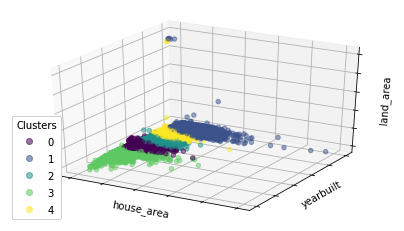

In [66]:
explore.k_cluster_3d(train_home,"house_area","yearbuilt","land_area", 5)

Execute the same process for the location group.

In [41]:
# explore.elbow(train_loc)

The ideal amount of clusters appears to be 7. 

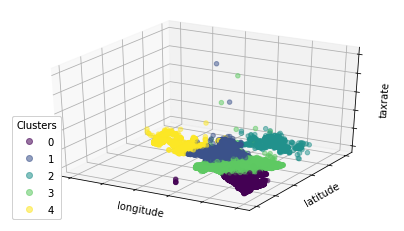

In [73]:
explore.k_cluster_3d(train_loc,"longitude","latitude","taxrate",5)

In [43]:
# explore.elbow(train_val)

The ideal amount of clusters appears to be 5.

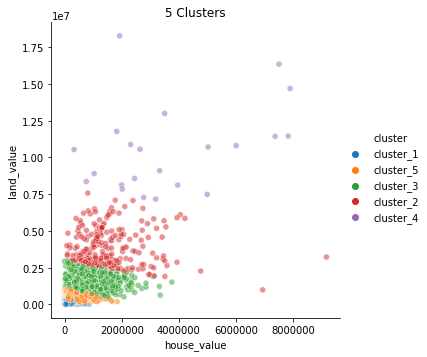

In [44]:
explore.k_cluster_2d(train_val, "house_value", "land_value", 5, n_min=5)

In [67]:
train_home_clusters = model.kmeans_model(train_home,5)
train_loc_clusters = model.kmeans_model(train_loc,5)
train_val_clusters = model.kmeans_model(train_val,5)

In [68]:
clusters = pd.DataFrame({"cluster_home":train_home_clusters,"cluster_loc":train_loc_clusters,"cluster_val":train_val_clusters},index=train.index)
train[["cluster_home","cluster_loc","cluster_val"]] = clusters

#### Test for significance

H0: There is no difference in mealogerrors between the clusters and the population  
H1: There is a difference between the clusters and the population  

Using the `test_significance` function in the `explore` module, test each clusters for significance by comparing each cluster's logerror to the population logerror (one sample t-test).

In [74]:
explore.test_significance(train.cluster_home, train)

,ttest,pval,stat_sig
0,-2.113706,0.034558,False
1,2.811889,0.004935,True
2,0.229653,0.818368,False
3,3.283401,0.001032,True
4,-3.695476,0.000222,True


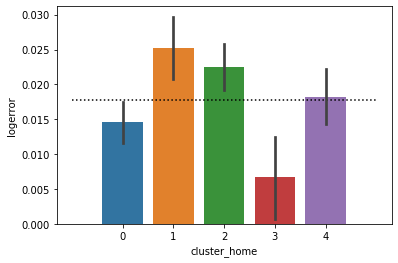

In [77]:
sns.barplot(train.cluster_home, train.logerror)
plt.hlines(train.logerror.mean(),-1,len(train.cluster_home.unique()),ls=":")

Logerrors for Cluster_Home 1 (Abnormally high tax rate) is higher than mean logerror.  
Logerrors for Cluster_Home 3 (Older houses) is significantly lower than mean logerror.  
Logerrors for Cluster_Home 4 (Abnormally high tax rate) is right about the mean logerror, but the difference in the means of this cluster is statistically significant.  

In [72]:
explore.test_significance(train.cluster_loc, train)

,ttest,pval,stat_sig
0,-4.387514,0.000012,True
1,0.443391,0.657489,False
2,-0.850554,0.395077,False
3,4.197217,0.000027,True
4,-0.021473,0.982870,False


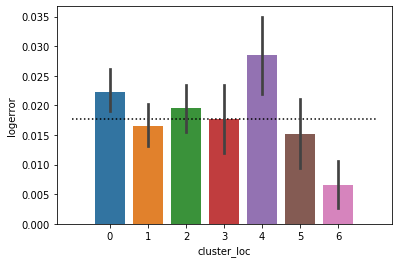

In [51]:
sns.barplot(train.cluster_loc, train.logerror)
plt.hlines(train.logerror.mean(),-1,len(train.cluster_loc.unique()),ls=":")

In [52]:
explore.test_significance(train.cluster_val, train)

,ttest,pval,stat_sig
0,0.280033,0.779454,False
1,-1.074869,0.282457,False
2,1.620120,0.105400,False
3,-1.068799,0.286750,False
4,-0.477600,0.639394,False


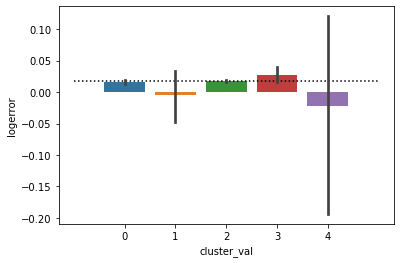

In [53]:
sns.barplot(train.cluster_val, train.logerror)
plt.hlines(train.logerror.mean(),-1,len(train.cluster_val.unique()),ls=":")

#### What clusters tell us about logerror differences
?? not sure until i see it in a plot

- properties with higher tax rate than normal have greater logerror difference
- properties with big land area and house area have greater logerror

## Model

In [54]:
X_train = train[["house_area","land_area","yearbuilt","latitude","longitude","taxrate","house_value","land_value","cluster_val","cluster_home","cluster_loc"]]
X_test = train[["house_area","land_area","yearbuilt","latitude","longitude","taxrate","house_value","land_value","cluster_val","cluster_home","cluster_loc"]]

X_train_nc = train[["house_area","land_area","yearbuilt","latitude","longitude","taxrate","house_value","land_value"]]
X_test_nc = train[["house_area","land_area","yearbuilt","latitude","longitude","taxrate","house_value","land_value"]]

y_train = train.logerror
y_test = test.logerror

In [55]:
X_train_scaled, X_test_scaled, scaler = split_scale.standard_scaler(X_train, X_test)
X_train_nc_scaled, X_test_nc_scaled, scaler = split_scale.standard_scaler(X_train_nc, X_test_nc)

In [56]:
from sklearn.linear_model import LassoCV

lassom = LassoCV()
lassom.fit(X_train_scaled, y_train)

coef = pd.Series(lassom.coef_, index = X_train.columns)
imp_coef = coef.sort_values()

print(imp_coef)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

house_value    -0.006404
land_value     -0.003944
latitude       -0.003331
cluster_loc    -0.002721
cluster_home    0.000207
yearbuilt       0.000569
longitude       0.001485
land_area       0.001563
taxrate         0.001899
cluster_val     0.002968
house_area      0.013516
dtype: float64
Lasso picked 11 variables and eliminated the other 0 variables


In [57]:
train = model.linear_model(X_train_scaled,y_train,train)

In [58]:
train.head()

,countyid,latitude,longitude,yearbuilt,bathroomcnt,bedroomcnt,house_area,land_area,whole_area,house_value,land_value,whole_value,taxrate,logerror,month,cluster_home,cluster_loc,cluster_val,lm
28235,6037,33960836,-118413033,1949.0,2.0,3,1895.0,7198.0,9093.0,85181.0,84978.0,170159.0,0.013674,-0.059434,4,0,6,2,0.018846
22023,6037,33895532,-118011549,1955.0,2.0,3,1294.0,4670.0,5964.0,84270.0,230957.0,315227.0,0.013173,0.266040,3,0,0,2,0.019517
56314,6037,33844205,-118119583,1950.0,1.0,3,1092.0,3908.0,5000.0,81388.0,140326.0,221714.0,0.013059,0.109513,7,0,0,2,0.017506
29544,6037,34071220,-117721874,1955.0,2.0,3,1274.0,5611.0,6885.0,88053.0,109929.0,197982.0,0.012802,0.012496,4,0,2,2,0.016246
11615,6037,34003315,-117949854,1958.0,2.0,4,1136.0,4806.0,5942.0,34292.0,15407.0,49699.0,0.017936,0.001586,2,0,2,2,0.018408


In [59]:
median_abs_error, r2 = model.evaluate(train.logerror,train.lm)

In [60]:
print(median_abs_error)
print(r2)

0.03497193610092299
0.004493169924685625


---

1. run a linear regression for every cluster

In [61]:
for c_number in X_train.cluster_home.unique():
    cluster = pd.DataFrame(X_train[X_train["cluster_home"]==c_number])
    print(cluster)

       house_area  land_area  yearbuilt  latitude  longitude   taxrate  \
28235      1895.0     7198.0     1949.0  33960836 -118413033  0.013674   
22023      1294.0     4670.0     1955.0  33895532 -118011549  0.013173   
56314      1092.0     3908.0     1950.0  33844205 -118119583  0.013059   
29544      1274.0     5611.0     1955.0  34071220 -117721874  0.012802   
11615      1136.0     4806.0     1958.0  34003315 -117949854  0.017936   
14062      1247.0     4629.0     1947.0  33965919 -118406755  0.012157   
11816      1361.0     4349.0     1955.0  33926773 -118016546  0.012057   
56594      1004.0     7246.0     1951.0  34420566 -119295339  0.031194   
9963        848.0     6299.0     1952.0  34042606 -117765066  0.013879   
40088       772.0     6369.0     1940.0  34063510 -118033220  0.015437   
65560      1100.0     5620.0     1949.0  34198809 -118520349  0.012349   
36977      1183.0     5729.0     1938.0  34177759 -118323974  0.011417   
41177       948.0     2052.0     1955.

In [62]:
cluster

,house_area,land_area,yearbuilt,latitude,longitude,taxrate,house_value,land_value,cluster_val,cluster_home,cluster_loc
27915,912.0,3730.0,1934.0,33852637,-118188196,0.017002,27521.0,16749.0,2,3,6
30236,2166.0,4326.0,1927.0,34037468,-118409541,0.012073,330000.0,1320000.0,3,3,6
13451,2350.0,20150.0,1928.0,34101300,-118327000,0.011004,389600.0,97400.0,2,3,1
14193,1819.0,3781.0,1908.0,34115737,-118194194,0.012412,115364.0,196606.0,2,3,2
56735,1764.0,2824.0,1906.0,33994905,-118275156,0.013706,43033.0,13643.0,2,3,6
57453,1462.0,6287.0,1904.0,34117081,-117789035,0.012067,129501.0,304727.0,2,3,2
13815,1472.0,6583.0,1927.0,34000303,-118291374,0.012531,70415.0,281664.0,2,3,6
29674,936.0,4062.0,1919.0,33731749,-118290748,0.012318,55608.0,222440.0,2,3,6
6486,1815.0,5465.0,1927.0,33968795,-118321384,0.013785,144974.0,310660.0,2,3,6
66352,2583.0,4651.0,1919.0,34059603,-118315383,0.012265,239192.0,507625.0,0,3,6


In [63]:
X_train[X_train.cluster_home==0]

,house_area,land_area,yearbuilt,latitude,longitude,taxrate,house_value,land_value,cluster_val,cluster_home,cluster_loc
28235,1895.0,7198.0,1949.0,33960836,-118413033,0.013674,85181.0,84978.0,2,0,6
22023,1294.0,4670.0,1955.0,33895532,-118011549,0.013173,84270.0,230957.0,2,0,0
56314,1092.0,3908.0,1950.0,33844205,-118119583,0.013059,81388.0,140326.0,2,0,0
29544,1274.0,5611.0,1955.0,34071220,-117721874,0.012802,88053.0,109929.0,2,0,2
11615,1136.0,4806.0,1958.0,34003315,-117949854,0.017936,34292.0,15407.0,2,0,2
14062,1247.0,4629.0,1947.0,33965919,-118406755,0.012157,177544.0,710189.0,0,0,6
11816,1361.0,4349.0,1955.0,33926773,-118016546,0.012057,91000.0,364000.0,2,0,0
56594,1004.0,7246.0,1951.0,34420566,-119295339,0.031194,25839.0,10313.0,2,0,5
9963,848.0,6299.0,1952.0,34042606,-117765066,0.013879,21806.0,109038.0,2,0,2
40088,772.0,6369.0,1940.0,34063510,-118033220,0.015437,51972.0,54374.0,2,0,2


In [64]:
lm=LinearRegression()
lm.fit(X_train_nc_scaled,y_train)
yhat = lm.predict(

SyntaxError: unexpected EOF while parsing (<ipython-input-64-4894a053d2fd>, line 3)

In [ ]:
def linear_model(X_train, y_train, df):
    lm=LinearRegression()
    lm.fit(X_train,y_train)
    lm_predictions=lm.predict(X_train)
    df['lm']=lm_predictions
    return df